In [67]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as mcolors
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


axis_label_fontsize = 14
title_fontsize = 13
legend_fontsize = 10
parent_nace_list = ["A","B","C","F","H","G"]
tick_label_fontsize =10
pd.set_option("display.max_columns",100)

colors = [
    "#2ab421",   # Less vivid green
    "#f93a2e",  # Vivid red
    "#d02670",  # Strong pink
    "#ff7a00",  # Bright orange
    "#1dd3c1",  # Vivid turquoise
    "#8a2be2",   # Electric purple
    "#ffafd2",  # Bright pink
    "#fff537",  # Bright yellow
    "#4589ff",  # Vibrant blue
    "#d4b237",  # Bold yellow-orange
    "#c677e2",  # Lively purple
    "#a2a9b0",  # Muted grayish blue
    "#baf0ce",  # Soft green
    "#b7e1ff",  # Light blue
    "#ebeced",  # Light gray
    "#dbc7ff",  # Pale purple
    "#6fdc8c",  # Bright green
]


## Historical low-carbon share of Hungary

In [68]:
df_final_consumption = pd.read_excel("data/7_2_annual_national_energy_balance_2014_2023.xlsx", sheet_name="2014")
df_final_consumption.columns = df_final_consumption.iloc[1,:]
df_final_consumption = pd.DataFrame([df_final_consumption.iloc[13,1:] - df_final_consumption.iloc[36,1:]])
df_final_consumption["year"] = 2014

for year in np.arange(2015,2023):
    df_temp = pd.read_excel("data/7_2_annual_national_energy_balance_2014_2023.xlsx", sheet_name=str(year))
    df_temp.columns = df_temp.iloc[1,:]
    df_temp = pd.DataFrame([df_temp.iloc[13,1:] - df_temp.iloc[36,1:]])
    df_temp["year"] = year
    
    df_final_consumption = pd.concat([df_final_consumption, df_temp], axis = 0)


for col in df_final_consumption:
    if (col != "Name") and (col != "year"):
        df_final_consumption[col] = df_final_consumption[col]*0.000278


df_final_consumption = df_final_consumption.reset_index(drop = True)
df_final_consumption["electricity_share"] = df_final_consumption["Electricity"] / (df_final_consumption["Electricity"] + df_final_consumption["Coal and coal products "] + df_final_consumption["Natural gas"] + df_final_consumption["Oil and petroleum products"])
df_final_consumption


1,Coal and coal products,Oil and petroleum products,Natural gas,Combustible renewables and waste,Nuclear,Water,Wind,Other non-combustible renewables,Electricity,Heat,Total,NaN,NaN,year,Solar,Geothermal,NaN,NaN,electricity_share
0,1.287969,68.614959,36.969552,4.688053,NaN,NaN,NaN,0.683602,24.333451,5.508848,142.086434,NaN,NaN,2014,NaN,NaN,NaN,NaN,0.185460
1,1.752243,74.886083,36.217701,4.733840,NaN,NaN,NaN,0.626890,25.472362,6.014252,149.703370,NaN,NaN,2015,NaN,NaN,NaN,NaN,0.184144
2,1.440267,74.038461,37.407402,5.117535,NaN,NaN,NaN,0.591862,26.218958,6.672834,151.487320,NaN,NaN,2016,NaN,NaN,NaN,NaN,0.188483
3,2.263756,80.221404,38.348905,5.458002,NaN,NaN,NaN,0.722244,27.265795,6.424302,160.704407,NaN,NaN,2017,NaN,NaN,NaN,NaN,0.184104
4,1.908813,85.626391,37.561025,6.364671,0.0,0.0,0.0,0.770338,28.070438,6.010360,166.312036,NaN,NaN,2018,NaN,NaN,NaN,NaN,0.183267
5,1.822372,86.738947,37.064378,7.059171,0.0,0.0,0.0,0.790354,28.626883,6.062902,168.165007,NaN,NaN,2019,NaN,NaN,NaN,NaN,0.185584
6,1.507960,80.509022,37.390889,7.867734,0.0,0.0,0.0,0.728360,27.793217,6.007302,161.804483,NaN,NaN,2020,NaN,NaN,NaN,NaN,0.188811
7,1.376924,88.142124,38.295112,8.850881,0.0,0.0,0.0,NaN,29.264393,6.555240,173.288649,NaN,NaN,2021,0.003058,0.800918,NaN,NaN,0.186304
8,1.131253,86.156648,30.929474,8.736067,0.0,0.0,0.0,NaN,28.980166,5.820486,162.686783,NaN,NaN,2022,0.003336,0.929354,NaN,NaN,0.196879


## Forecast Hungary Electricity Mix

In [69]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# --- Linear Fit Function ---
def estimate_lowcarbon_elec_mix_growth(df_temp):
    lowcarbon_elec_vals = df_temp["low-carbon_elec_share"].values
    years = df_temp["year"].values.reshape(-1,1)  # use actual years
    elec_model = LinearRegression()
    elec_model.fit(years, lowcarbon_elec_vals)
    elec_coef = elec_model.coef_[0]
    elec_intercept = elec_model.intercept_
    return elec_coef, elec_intercept

# Subset for 2020–2024 for fitting the trend
df_share = pd.read_csv("data/low-carbon_electricity_share_Hungary_[2014-2024].csv")
df_fit = df_share[(df_share.year >= 2020) & (df_share.year <= 2024)]
elec_coef, elec_intercept = estimate_lowcarbon_elec_mix_growth(df_fit)

# --- Linear Forecast ---
forecast_years = np.arange(2025, 2051)  # 2025 to 2050
linear_forecast = elec_intercept + elec_coef * forecast_years
linear_forecast = np.clip(linear_forecast, 0, 1)  # keep values between 0 and 1

# --- Combine actual values from 2014-2024 with forecast ---
df_actual = df_share[(df_share.year >= 2014) & (df_share.year <= 2024)][["year", "low-carbon_elec_share"]]

df_linear_forecast = pd.concat([
    df_actual,  # actual values 2014-2024
    pd.DataFrame({"year": forecast_years, "low-carbon_elec_share": linear_forecast})  # forecast 2025+
], ignore_index=True)

df_linear_forecast["year"] = df_linear_forecast["year"].astype(int)


## Low-carbon electricity share of observed years [2020-2023]

In [82]:
df = pd.read_csv("results/energy_consumption_and_trends_firms_2020-2024.csv")
elec_vals = df.loc[:,["elec_consumption_KWH_2020",
          "elec_consumption_KWH_2021",
          "elec_consumption_KWH_2022",
          "elec_consumption_KWH_2023",
          "elec_consumption_KWH_2024"]].sum().values /df.loc[:,["total_consumption_KWH_2020",
          "total_consumption_KWH_2021",
          "total_consumption_KWH_2022",
          "total_consumption_KWH_2023",
          "total_consumption_KWH_2024"]].sum().values

fossil_vals = 1 - elec_vals

lowcarbon_elec_vals = df.loc[:,["low-carbon_elec_consumption_KWH_2020",
          "low-carbon_elec_consumption_KWH_2021",
          "low-carbon_elec_consumption_KWH_2022",
          "low-carbon_elec_consumption_KWH_2023",
          "low-carbon_elec_consumption_KWH_2024"]].sum().values /df.loc[:,["total_consumption_KWH_2020",
          "total_consumption_KWH_2021",
          "total_consumption_KWH_2022",
          "total_consumption_KWH_2023",
          "total_consumption_KWH_2024"]].sum().values

df_lowcarbon_elec = pd.DataFrame({"source_year":[np.nan]*5,
                                   "energy_consumed":lowcarbon_elec_vals,
                                   "type":["lowcarbon_elec"]*5,
                                   "year":[2020,2021,2022,2023,2024]
                                   })

df_elec = pd.DataFrame({"source_year":[np.nan]*5,
                              "energy_consumed":elec_vals,
                              "type":["elec"]*5,
                              "year":[2020,2021,2022,2023,2024]
                              })

df_fossil = pd.DataFrame({"source_year":[np.nan]*5,
                              "energy_consumed":fossil_vals,
                              "type":["fossil"]*5,
                              "year":[2020,2021,2022,2023,2024]
                              })

df_observed = pd.concat([df_elec, df_lowcarbon_elec, df_fossil], axis = 0)
df_observed["scenario"] = "observed"
df_observed

,source_year,energy_consumed,type,year,scenario
0,NaN,0.177034,elec,2020,observed
1,NaN,0.242814,elec,2021,observed
2,NaN,0.321031,elec,2022,observed
3,NaN,0.275253,elec,2023,observed
4,NaN,0.195534,elec,2024,observed
0,NaN,0.109404,lowcarbon_elec,2020,observed
1,NaN,0.154029,lowcarbon_elec,2021,observed
2,NaN,0.210581,lowcarbon_elec,2022,observed
3,NaN,0.195901,lowcarbon_elec,2023,observed
4,NaN,0.144269,lowcarbon_elec,2024,observed


## Low-carbon electricity share of previous years [2014 - 2019]

In [83]:
# --- Historical data ---
df_hist = df_final_consumption.copy(deep=True).loc[:, ["year", "electricity_share"]]
df_hist = df_hist[df_hist.year <= 2020].reset_index(drop=True)

# --- Electricity (total) ---
df_elec = df_hist.copy(deep=True)
df_elec["energy_consumed"] = df_elec["electricity_share"]
df_elec["type"] = "elec"
df_elec["source_year"] = np.nan
df_elec = df_elec[["source_year", "energy_consumed", "type", "year"]]

# --- Lowcarbon electricity share ---
df_lowcarbon = df_hist.copy(deep=True)
df_lowcarbon["energy_consumed"] = df_lowcarbon["electricity_share"] * df_linear_forecast[df_linear_forecast.year <= 2020]["low-carbon_elec_share"].values
df_lowcarbon["type"] = "lowcarbon_elec"
df_lowcarbon["source_year"] = np.nan
df_lowcarbon = df_lowcarbon[["source_year", "energy_consumed", "type", "year"]]

# --- Fossil share = 1 - elec ---
df_fossil = df_hist.copy(deep=True)
df_fossil["energy_consumed"] = 1 - df_fossil["electricity_share"]
df_fossil["type"] = "fossil"
df_fossil["source_year"] = np.nan
df_fossil = df_fossil[["source_year", "energy_consumed", "type", "year"]]

# --- Combine all types ---
df_hist_final = pd.concat([df_elec, df_lowcarbon, df_fossil], ignore_index=True)
df_hist_final = df_hist_final.sort_values(by=["year", "type"]).reset_index(drop=True)

df_hist_final["scenario"] = "historical"
# df_hist_final


## Calculate TRANS-LIN & TRANS-EXP Scenarios

In [84]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm

df_trans = pd.read_csv("results/energy_consumption_and_trends_firms_2020-2024.csv")

# Initialize columns to store nearest positive matches
for col in ["closest_positive_nace4", "closest_positive_revenue", "closest_positive_employment",
            "closest_positive_nace2", "closest_positive_elec_share_growth_robust", "closest_positive_index",
            "closest_positive_elec_share_intercept_robust", "closest_positive_elec_share_exp_growth_robust", "closest_positive_elec_share_exp_intercept_robust",
            "distance_to_closest"]:
    df_trans[col] = np.nan

nace2_fallback_count = 0
fallback_nace4_codes = []

scaler = StandardScaler()

years_omit = ["2020","2021","2022","2023","2024"]

# Helper function to copy all scenarios from closest positive
def copy_all_scenarios(row, closest_firm, growth_type="elec_share"):
    # allyears
    row[f"closest_positive_{growth_type}_growth_robust"] = closest_firm[f"{growth_type}_growth_robust"]
    row[f"closest_positive_{growth_type}_intercept_robust"] = closest_firm[f"{growth_type}_intercept_robust"]

    # each year omitted
    for y in years_omit:
        row[f"{growth_type}_growth_omit{y}_robust"] = closest_firm.get(f"{growth_type}_growth_omit{y}_robust", np.nan)
        row[f"{growth_type}_intercept_omit{y}_robust"] = closest_firm.get(f"{growth_type}_intercept_omit{y}_robust", np.nan)
    return row

# Iterate over each firm
for index, row in tqdm(df_trans.iterrows(), total=len(df_trans)):
    replace_growth = row['elec_share_growth_robust'] < 0
    replace_exp = row['elec_share_exp_growth_robust'] < 0

    if not (replace_growth or replace_exp):
        continue

    # Step 1: Match within same nace4
    potential_matches = df_trans[df_trans['nace4'] == row['nace4']]

    if replace_growth:
        matches_growth = potential_matches[potential_matches['elec_share_growth_robust'] > 0]
    else:
        matches_growth = pd.DataFrame()

    if replace_exp:
        matches_exp = potential_matches[potential_matches['elec_share_exp_growth_robust'] > 0]
    else:
        matches_exp = pd.DataFrame()

    # Step 2: Fallback to nace2
    if replace_growth and matches_growth.empty:
        matches_growth = df_trans[(df_trans['nace2'] == row['nace2']) & (df_trans['elec_share_growth_robust'] > 0)]
        nace2_fallback_count += 1
        fallback_nace4_codes.append(row['nace4'])

    if replace_exp and matches_exp.empty:
        matches_exp = df_trans[(df_trans['nace2'] == row['nace2']) & (df_trans['elec_share_exp_growth_robust'] > 0)]
        nace2_fallback_count += 1
        fallback_nace4_codes.append(row['nace4'])

    # Step 3: Find closest positive elec_growth
    if replace_growth and not matches_growth.empty:
        neg_feat = np.array([[row['avg_revenue'], row['avg_employment']]])
        pos_feat = matches_growth[['avg_revenue', 'avg_employment']].values

        scaler.fit(pos_feat)
        scaled_pos = scaler.transform(pos_feat)
        scaled_neg = scaler.transform(neg_feat)

        nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
        nn.fit(scaled_pos)
        dist, idx = nn.kneighbors(scaled_neg)

        closest_idx = matches_growth.index[idx[0][0]]
        closest_firm = matches_growth.loc[closest_idx]

        # Save info
        row = copy_all_scenarios(row, closest_firm, growth_type="elec_share")
        row['closest_positive_nace4'] = closest_firm['nace4']
        row['closest_positive_nace2'] = closest_firm['nace2']
        row['closest_positive_revenue'] = closest_firm['avg_revenue']
        row['closest_positive_employment'] = closest_firm['avg_employment']
        row['closest_positive_index'] = closest_idx
        row['distance_to_closest'] = dist[0][0]

    # Step 4: Find closest positive elec_exp_growth
    if replace_exp and not matches_exp.empty:
        neg_feat = np.array([[row['avg_revenue'], row['avg_employment']]])
        pos_feat = matches_exp[['avg_revenue', 'avg_employment']].values

        scaler.fit(pos_feat)
        scaled_pos = scaler.transform(pos_feat)
        scaled_neg = scaler.transform(neg_feat)

        nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
        nn.fit(scaled_pos)
        dist, idx = nn.kneighbors(scaled_neg)

        closest_idx = matches_exp.index[idx[0][0]]
        closest_firm = matches_exp.loc[closest_idx]

        # Save info
        row = copy_all_scenarios(row, closest_firm, growth_type="elec_share_exp")
        row['closest_positive_nace4'] = closest_firm['nace4']
        row['closest_positive_nace2'] = closest_firm['nace2']
        row['closest_positive_revenue'] = closest_firm['avg_revenue']
        row['closest_positive_employment'] = closest_firm['avg_employment']
        row['closest_positive_index'] = closest_idx
        row['distance_to_closest'] = dist[0][0]

    df_trans.loc[index] = row

# Step 5: Replace negatives in all allyears + omitted columns
for y in ["_robust"] + [f"_omit{year}_robust" for year in years_omit]:
    df_trans[f"trans_elec_share_growth{y}"] = df_trans[f"elec_share_growth{y}"].where(df_trans[f"elec_share_growth{y}"] >= 0, df_trans['closest_positive_elec_share_growth_robust'])
    df_trans[f"trans_elec_share_intercept{y}"] = df_trans[f"elec_share_intercept{y}"].where(df_trans[f"elec_share_growth{y}"] >= 0, df_trans['closest_positive_elec_share_intercept_robust'])
    df_trans[f"trans_elec_share_exp_growth{y}"] = df_trans[f"elec_share_exp_growth{y}"].where(df_trans[f"elec_share_exp_growth{y}"] >= 0, df_trans['closest_positive_elec_share_exp_growth_robust'])
    df_trans[f"trans_elec_share_exp_intercept{y}"] = df_trans[f"elec_share_exp_intercept{y}"].where(df_trans[f"elec_share_exp_growth{y}"] >= 0, df_trans['closest_positive_elec_share_exp_intercept_robust'])


df_trans.to_csv("results/energy_consumption_and_trends_with_transition_firms_2020-2024.csv", index = False)

  0%|          | 0/77 [00:00<?, ?it/s]

100%|██████████| 77/77 [00:04<00:00, 15.63it/s]


## 1) business-as-usual (linear) scenario

In [85]:
import pandas as pd
import numpy as np

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 400)

# Load data
df_bau_LIN = pd.read_csv(
    "results/energy_consumption_and_trends_firms_2020-2024.csv"
)

# Define slope/intercept sets
scenario_sets = {
    "all_years": {"growth": "elec_share_growth_robust", "intercept": "elec_share_intercept_robust"},
    "omit2020": {"growth": "elec_share_growth_omit2020_robust", "intercept": "elec_share_intercept_omit2020_robust"},
    "omit2021": {"growth": "elec_share_growth_omit2021_robust", "intercept": "elec_share_intercept_omit2021_robust"},
    "omit2022": {"growth": "elec_share_growth_omit2022_robust", "intercept": "elec_share_intercept_omit2022_robust"},
    "omit2023": {"growth": "elec_share_growth_omit2023_robust", "intercept": "elec_share_intercept_omit2023_robust"},
    "omit2024": {"growth": "elec_share_growth_omit2024_robust", "intercept": "elec_share_intercept_omit2024_robust"},
}

# --- Build projections (long format) ---
# --- Build projections (long format) ---
dfs_long = []
for scenario_name, cols in scenario_sets.items():
    growth = df_bau_LIN[cols["growth"]]
    intercept = df_bau_LIN[cols["intercept"]]

    projections = []
    i = 5  # starting index for years 2025+
    for year in range(2025, 2051):
        elec_share = (growth * i + intercept).clip(0, 1)
        fossil_share = 1 - elec_share

        # Total electricity and fossil consumption
        elec_kwh = df_bau_LIN["avg_total_consumption_KWH"] * elec_share
        fossil_kwh = df_bau_LIN["avg_total_consumption_KWH"] * fossil_share

        # --- Low-carbon electricity consumption ---
        lowcarbon_elec_share_year = df_linear_forecast.loc[df_linear_forecast.year == year, "low-carbon_elec_share"].values[0]
        lowcarbon_elec_kwh = elec_kwh * lowcarbon_elec_share_year  # multiply by electricity consumed

        projections.append(pd.DataFrame({
            "year": year,
            "type": ["elec","lowcarbon_elec","fossil"],
            "energy_consumed": [
                elec_kwh.sum() / df_bau_LIN["avg_total_consumption_KWH"].sum(),
                lowcarbon_elec_kwh.sum() / df_bau_LIN["avg_total_consumption_KWH"].sum(),
                fossil_kwh.sum() / df_bau_LIN["avg_total_consumption_KWH"].sum()
            ],
            "scenario": scenario_name
        }))
        i += 1

    dfs_long.append(pd.concat(projections, axis=0))

df_bau_LIN_long = pd.concat(dfs_long, axis=0).reset_index(drop=True)


df_bau_LIN_long = pd.concat(dfs_long, axis=0).reset_index(drop=True)

# Add historical + observed if available
df_bau_LIN_long = pd.concat([df_observed, df_hist_final, df_bau_LIN_long], axis=0, ignore_index=True)

# Filter valid
df_bau_LIN_long = df_bau_LIN_long[df_bau_LIN_long["energy_consumed"] <= 1]

# --- Prepare envelope for uncertainty band ---
df_env = (
    df_bau_LIN_long[df_bau_LIN_long["type"] == "elec"]
    .groupby("year")
    .agg(min_elec=("energy_consumed", "min"),
         max_elec=("energy_consumed", "max"))
    .reset_index()
)

# Baseline series for plotting
df_baseline = df_bau_LIN_long[(df_bau_LIN_long["type"] == "elec") & (df_bau_LIN_long["scenario"] == "all_years")]

# Spaghetti: all omit-year scenarios except baseline
df_spaghetti = df_bau_LIN_long[(df_bau_LIN_long["type"] == "elec") & (df_bau_LIN_long["scenario"].str.contains("omit"))]

print(df_bau_LIN_long.head())
print(df_env.head())
print(df_baseline.head())
print(df_spaghetti.head())

# df_bau_LIN_long.to_csv("results/df_bau_LIN_long.csv", index = False)


   source_year  energy_consumed  type  year  scenario
0          NaN         0.177034  elec  2020  observed
1          NaN         0.242814  elec  2021  observed
2          NaN         0.321031  elec  2022  observed
3          NaN         0.275253  elec  2023  observed
4          NaN         0.195534  elec  2024  observed
   year  min_elec  max_elec
0  2014  0.185460  0.185460
1  2015  0.184144  0.184144
2  2016  0.188483  0.188483
3  2017  0.184104  0.184104
4  2018  0.183267  0.183267
    source_year  energy_consumed  type  year   scenario
36          NaN         0.245416  elec  2025  all_years
39          NaN         0.255006  elec  2026  all_years
42          NaN         0.262486  elec  2027  all_years
45          NaN         0.267354  elec  2028  all_years
48          NaN         0.269894  elec  2029  all_years
     source_year  energy_consumed  type  year  scenario
114          NaN         0.223186  elec  2025  omit2020
117          NaN         0.231956  elec  2026  omit2020
120 

In [86]:
df_bau_LIN_long.type.unique()

array(['elec', 'lowcarbon_elec', 'fossil'], dtype=object)

## 2) business-as-usual (exponential) scenario

In [87]:
df_bau_EXP = pd.read_csv("results/energy_consumption_and_trends_firms_2020-2024.csv")
df_bau_EXP
import pandas as pd
import numpy as np

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 400)

# Load data
df_bau_EXP = pd.read_csv(
    "results/energy_consumption_and_trends_firms_2020-2024.csv"
)

# Define slope/intercept sets for exponential scenario
scenario_sets_exp = {
    "all_years": {"growth": "elec_share_exp_growth_robust", "intercept": "elec_share_exp_intercept_robust"},
    "omit2020": {"growth": "elec_share_exp_growth_omit2020_robust", "intercept": "elec_share_exp_intercept_omit2020_robust"},
    "omit2021": {"growth": "elec_share_exp_growth_omit2021_robust", "intercept": "elec_share_exp_intercept_omit2021_robust"},
    "omit2022": {"growth": "elec_share_exp_growth_omit2022_robust", "intercept": "elec_share_exp_intercept_omit2022_robust"},
    "omit2023": {"growth": "elec_share_exp_growth_omit2023_robust", "intercept": "elec_share_exp_intercept_omit2023_robust"},
    "omit2024": {"growth": "elec_share_exp_growth_omit2024_robust", "intercept": "elec_share_exp_intercept_omit2024_robust"},
}

# --- Build exponential projections (long format) ---
dfs_long_exp = []
for scenario_name, cols in scenario_sets_exp.items():
    growth = df_bau_EXP[cols["growth"]]
    intercept = df_bau_EXP[cols["intercept"]]

    projections = []
    i = 5  # starting index like before
    for year in range(2025, 2051):
        # Exponential share calculation
        elec_share = (np.exp(intercept) * np.exp(i * growth)).clip(0, 1)
        fossil_share = 1 - elec_share

        # Compute consumption
        elec_kwh = df_bau_EXP["avg_total_consumption_KWH"] * elec_share
        fossil_kwh = df_bau_EXP["avg_total_consumption_KWH"] * fossil_share

        # Low-carbon electricity share for the year
        lowcarbon_elec_share_year = df_linear_forecast.loc[
            df_linear_forecast.year == year, "low-carbon_elec_share"
        ].values[0]
        lowcarbon_elec_kwh = elec_kwh * lowcarbon_elec_share_year

        # Add all three energy types
        projections.append(pd.DataFrame({
            "year": [year, year, year],
            "type": ["elec", "lowcarbon_elec", "fossil"],
            "energy_consumed": [
                elec_kwh.sum() / df_bau_EXP["avg_total_consumption_KWH"].sum(),
                lowcarbon_elec_kwh.sum() / df_bau_EXP["avg_total_consumption_KWH"].sum(),
                fossil_kwh.sum() / df_bau_EXP["avg_total_consumption_KWH"].sum()
            ],
            "scenario": [scenario_name] * 3
        }))
        i += 1

    dfs_long_exp.append(pd.concat(projections, axis=0))

df_bau_EXP_long = pd.concat(dfs_long_exp, axis=0).reset_index(drop=True)

# Add historical + observed if available
df_bau_EXP_long = pd.concat([df_observed, df_hist_final, df_bau_EXP_long], axis=0, ignore_index=True)

# Filter valid shares <= 1
df_bau_EXP_long = df_bau_EXP_long[df_bau_EXP_long["energy_consumed"] <= 1]

# --- Prepare envelope for uncertainty band ---
df_env_exp = (
    df_bau_EXP_long[df_bau_EXP_long["type"] == "elec"]
    .groupby("year")
    .agg(min_elec=("energy_consumed", "min"),
         max_elec=("energy_consumed", "max"))
    .reset_index()
)

# Baseline series for plotting
df_baseline_exp = df_bau_EXP_long[
    (df_bau_EXP_long["type"] == "elec") &
    (df_bau_EXP_long["scenario"] == "all_years")
]

# Spaghetti: all omit-year scenarios except baseline
df_spaghetti_exp = df_bau_EXP_long[
    (df_bau_EXP_long["type"] == "elec") &
    (df_bau_EXP_long["scenario"].str.contains("omit"))
]

print(df_bau_EXP_long.head())
print(df_env_exp.head())
print(df_baseline_exp.head())
print(df_spaghetti_exp.head())

# Optional: save for reuse
df_bau_EXP_long.to_csv("results/df_bau_EXP_long.csv", index=False)




   source_year  energy_consumed  type  year  scenario
0          NaN         0.177034  elec  2020  observed
1          NaN         0.242814  elec  2021  observed
2          NaN         0.321031  elec  2022  observed
3          NaN         0.275253  elec  2023  observed
4          NaN         0.195534  elec  2024  observed
   year  min_elec  max_elec
0  2014  0.185460  0.185460
1  2015  0.184144  0.184144
2  2016  0.188483  0.188483
3  2017  0.184104  0.184104
4  2018  0.183267  0.183267
    source_year  energy_consumed  type  year   scenario
36          NaN         0.268101  elec  2025  all_years
39          NaN         0.298406  elec  2026  all_years
42          NaN         0.306642  elec  2027  all_years
45          NaN         0.312038  elec  2028  all_years
48          NaN         0.315742  elec  2029  all_years
     source_year  energy_consumed  type  year  scenario
114          NaN         0.258506  elec  2025  omit2020
117          NaN         0.269147  elec  2026  omit2020
120 

## 3) transition scenario (linear)

In [88]:
import pandas as pd
import numpy as np

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 400)

# --- Load data ---

df = pd.read_csv("results/energy_consumption_and_trends_with_transition_firms_2020-2024.csv")

# --- Define slope/intercept sets for transition scenario ---
# Use the dataframe already prepared with transition slopes/intercepts
transition_sets = {
    "all_years": {"growth": "trans_elec_share_growth_robust", "intercept": "trans_elec_share_intercept_robust"},
    "omit2020": {"growth": "trans_elec_share_growth_omit2020_robust", "intercept": "trans_elec_share_intercept_omit2020_robust"},
    "omit2021": {"growth": "trans_elec_share_growth_omit2021_robust", "intercept": "trans_elec_share_intercept_omit2021_robust"},
    "omit2022": {"growth": "trans_elec_share_growth_omit2022_robust", "intercept": "trans_elec_share_intercept_omit2022_robust"},
    "omit2023": {"growth": "trans_elec_share_growth_omit2023_robust", "intercept": "trans_elec_share_intercept_omit2023_robust"},
    "omit2024": {"growth": "trans_elec_share_growth_omit2024_robust", "intercept": "trans_elec_share_intercept_omit2024_robust"},
}


# --- Build projections (long format) ---
dfs_long_trans = []

for scenario_name, cols in transition_sets.items():
    growth = df[cols["growth"]]
    intercept = df[cols["intercept"]]

    projections = []
    step = 5  # offset for 2025
    for year in range(2025, 2051):
        # Linear transition shares
        elec_share = (growth * step + intercept).clip(0, 1)
        fossil_share = 1 - elec_share

        # Energy consumed (normalized)
        elec_kwh = df["avg_total_consumption_KWH"] * elec_share
        fossil_kwh = df["avg_total_consumption_KWH"] * fossil_share
        
        # Lowcarbon electricity share for the year
        lowcarbon_elec_share_year = df_linear_forecast.loc[
            df_linear_forecast.year == year, "low-carbon_elec_share"
        ].values[0]
        lowcarbon_elec_kwh = elec_kwh * lowcarbon_elec_share_year

        projections.append(pd.DataFrame({
            "year": year,
            "type": ["elec", "lowcarbon_elec", "fossil"],
            "energy_consumed": [
                elec_kwh.sum() / df["avg_total_consumption_KWH"].sum(),
                lowcarbon_elec_kwh.sum() / df["avg_total_consumption_KWH"].sum(),
                fossil_kwh.sum() / df["avg_total_consumption_KWH"].sum()
            ],
            "scenario": scenario_name
        }))
        step += 1

    dfs_long_trans.append(pd.concat(projections, axis=0))

# Combine all projections
df_transition_long = pd.concat(dfs_long_trans, axis=0).reset_index(drop=True)

# Add historical + observed if available
df_transition_long = pd.concat([df_observed, df_hist_final, df_transition_long], axis=0, ignore_index=True)

# Filter valid
df_transition_long = df_transition_long[df_transition_long["energy_consumed"] <= 1]

# --- Prepare envelope for uncertainty band ---
df_env_trans = (
    df_transition_long[df_transition_long["type"] == "elec"]
    .groupby("year")
    .agg(
        min_elec=("energy_consumed", "min"),
        max_elec=("energy_consumed", "max")
    )
    .reset_index()
)

# Baseline and spaghetti for plotting
df_baseline_trans = df_transition_long[(df_transition_long["type"] == "elec") & (df_transition_long["scenario"] == "all_years")]
df_spaghetti_trans = df_transition_long[(df_transition_long["type"] == "elec") & (df_transition_long["scenario"].str.contains("omit"))]

print(df_transition_long.head())
print(df_env_trans.head())
print(df_baseline_trans.head())
print(df_spaghetti_trans.head())

df_transition_long.to_csv("results/df_transition_long.csv", index = False)


   source_year  energy_consumed  type  year  scenario
0          NaN         0.177034  elec  2020  observed
1          NaN         0.242814  elec  2021  observed
2          NaN         0.321031  elec  2022  observed
3          NaN         0.275253  elec  2023  observed
4          NaN         0.195534  elec  2024  observed
   year  min_elec  max_elec
0  2014  0.185460  0.185460
1  2015  0.184144  0.184144
2  2016  0.188483  0.188483
3  2017  0.184104  0.184104
4  2018  0.183267  0.183267
    source_year  energy_consumed  type  year   scenario
36          NaN         0.378176  elec  2025  all_years
39          NaN         0.412748  elec  2026  all_years
42          NaN         0.438713  elec  2027  all_years
45          NaN         0.457867  elec  2028  all_years
48          NaN         0.468769  elec  2029  all_years
     source_year  energy_consumed  type  year  scenario
114          NaN         0.350501  elec  2025  omit2020
117          NaN         0.368996  elec  2026  omit2020
120 

## 4) transition scenario (exponential)

In [89]:
import pandas as pd
import numpy as np

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 400)

# --- Use the dataframe already prepared with transition slopes/intercepts ---
# df already contains exponential transition growth/intercept columns
df = pd.read_csv("results/energy_consumption_and_trends_with_transition_firms_2020-2024.csv")


# --- Define exponential transition scenario sets ---
transition_sets_exp = {
    "all_years": {"growth": "trans_elec_share_exp_growth_robust", "intercept": "trans_elec_share_exp_intercept_robust"},
    "omit2020": {"growth": "trans_elec_share_exp_growth_omit2020_robust", "intercept": "trans_elec_share_exp_intercept_omit2020_robust"},
    "omit2021": {"growth": "trans_elec_share_exp_growth_omit2021_robust", "intercept": "trans_elec_share_exp_intercept_omit2021_robust"},
    "omit2022": {"growth": "trans_elec_share_exp_growth_omit2022_robust", "intercept": "trans_elec_share_exp_intercept_omit2022_robust"},
    "omit2023": {"growth": "trans_elec_share_exp_growth_omit2023_robust", "intercept": "trans_elec_share_exp_intercept_omit2023_robust"},
    "omit2024": {"growth": "trans_elec_share_exp_growth_omit2024_robust", "intercept": "trans_elec_share_exp_intercept_omit2024_robust"},
}



# --- Build projections (long format) ---
dfs_long_trans_exp = []

for scenario_name, cols in transition_sets_exp.items():
    growth = df[cols["growth"]]
    intercept = df[cols["intercept"]]

    projections = []
    step = 1  # start step for 2025
    for year in range(2025, 2051):
        # Exponential transition shares
        elec_share = (np.exp(intercept) * (np.exp(growth * step))).clip(0, 1)
        fossil_share = 1 - elec_share

        # Energy consumed (normalized)
        elec_kwh = df["avg_total_consumption_KWH"] * elec_share
        fossil_kwh = df["avg_total_consumption_KWH"] * fossil_share

        # Low-carbon electricity share for the year
        lowcarbon_elec_share_year = df_linear_forecast.loc[
            df_linear_forecast.year == year, "low-carbon_elec_share"
        ].values[0]
        lowcarbon_elec_kwh = elec_kwh * lowcarbon_elec_share_year

        projections.append(pd.DataFrame({
            "year": year,
            "type": ["elec", "lowcarbon_elec", "fossil"],
            "energy_consumed": [
                elec_kwh.sum() / df["avg_total_consumption_KWH"].sum(),
                lowcarbon_elec_kwh.sum() / df["avg_total_consumption_KWH"].sum(),
                fossil_kwh.sum() / df["avg_total_consumption_KWH"].sum()
            ],
            "scenario": scenario_name
        }))
        step += 1

    dfs_long_trans_exp.append(pd.concat(projections, axis=0))

# Combine all projections
df_transition_long_exp = pd.concat(dfs_long_trans_exp, axis=0).reset_index(drop=True)

# Add historical + observed if available
df_transition_long_exp = pd.concat([df_observed, df_hist_final, df_transition_long_exp], axis=0, ignore_index=True)

# Filter valid
df_transition_long_exp = df_transition_long_exp[df_transition_long_exp["energy_consumed"] <= 1]

# --- Prepare envelope for uncertainty band ---
df_env_trans_exp = (
    df_transition_long_exp[df_transition_long_exp["type"] == "elec"]
    .groupby("year")
    .agg(
        min_elec=("energy_consumed", "min"),
        max_elec=("energy_consumed", "max")
    )
    .reset_index()
)

# Baseline and spaghetti for plotting
df_baseline_trans_exp = df_transition_long_exp[(df_transition_long_exp["type"] == "elec") & (df_transition_long_exp["scenario"] == "all_years")]
df_spaghetti_trans_exp = df_transition_long_exp[(df_transition_long_exp["type"] == "elec") & (df_transition_long_exp["scenario"].str.contains("omit"))]

print(df_transition_long_exp.head())
print(df_env_trans_exp.head())
print(df_baseline_trans_exp.head())
print(df_spaghetti_trans_exp.head())

df_transition_long_exp.to_csv("results/df_transition_long_exp.csv", index = False)


   source_year  energy_consumed  type  year  scenario
0          NaN         0.177034  elec  2020  observed
1          NaN         0.242814  elec  2021  observed
2          NaN         0.321031  elec  2022  observed
3          NaN         0.275253  elec  2023  observed
4          NaN         0.195534  elec  2024  observed
   year  min_elec  max_elec
0  2014  0.185460  0.185460
1  2015  0.184144  0.184144
2  2016  0.188483  0.188483
3  2017  0.184104  0.184104
4  2018  0.183267  0.183267
    source_year  energy_consumed  type  year   scenario
36          NaN         0.110206  elec  2025  all_years
39          NaN         0.151417  elec  2026  all_years
42          NaN         0.221493  elec  2027  all_years
45          NaN         0.346216  elec  2028  all_years
48          NaN         0.442963  elec  2029  all_years
     source_year  energy_consumed  type  year  scenario
114          NaN         0.135304  elec  2025  omit2020
117          NaN         0.183864  elec  2026  omit2020
120 

## Plot all scenarios

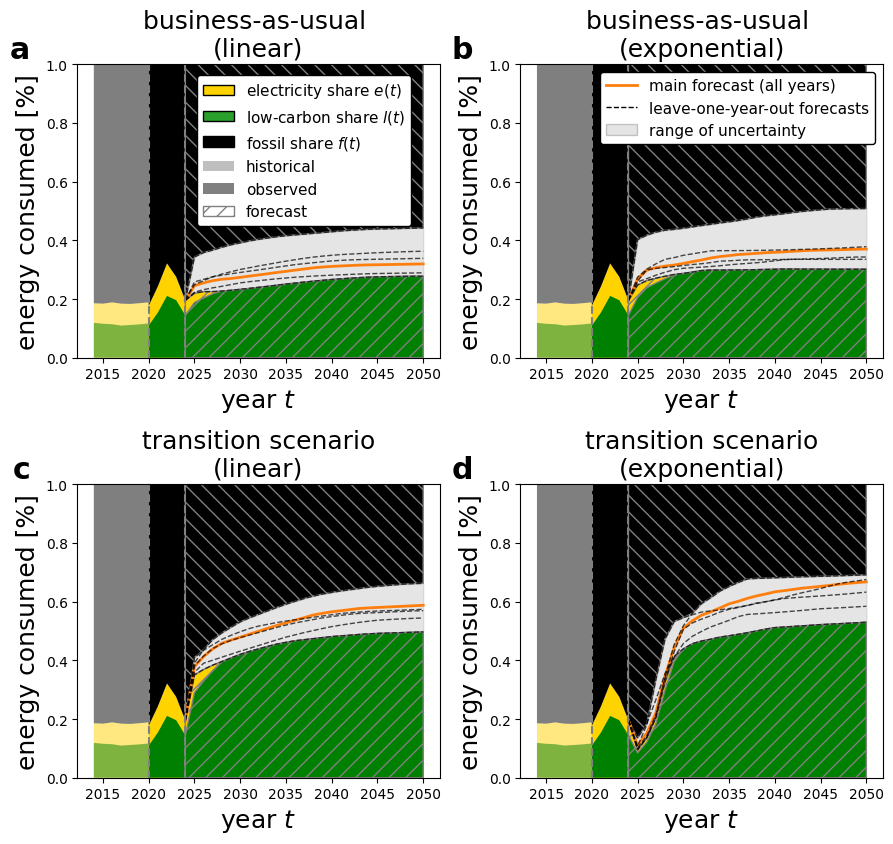

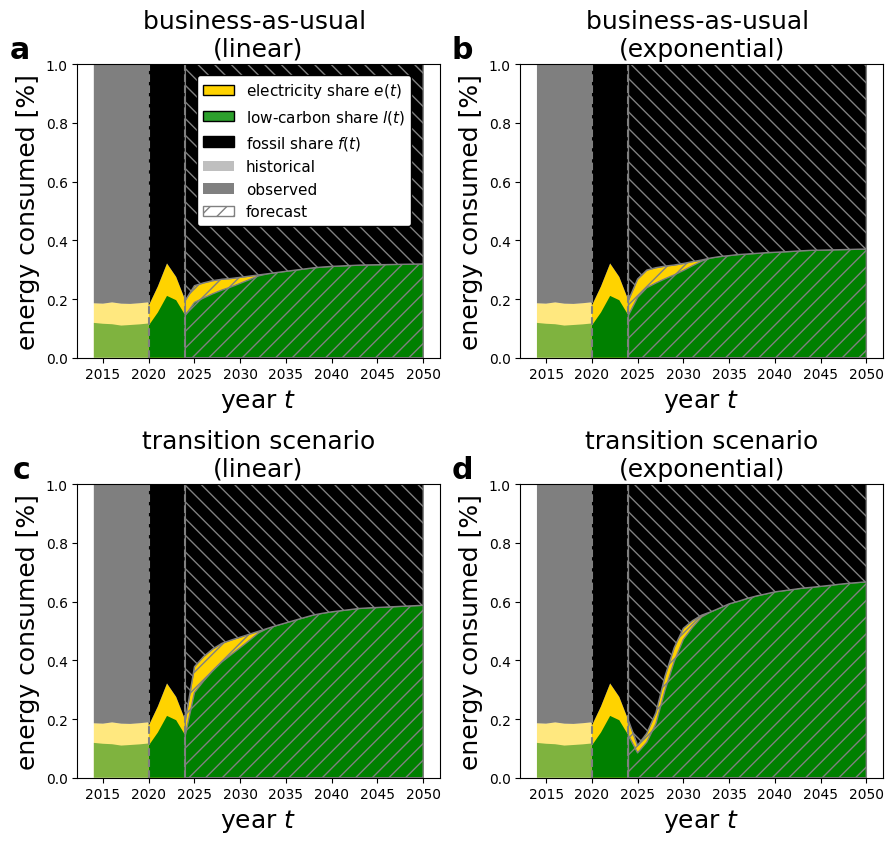

In [92]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd

def plot_combined_scenarios(plot_data_list, mode="all", save_path=None):
    """
    Plot combined electricity/fossil energy consumption scenarios (historical, observed, forecast) 
    for multiple datasets in a 2x2 subplot layout.

    Parameters
    ----------
    plot_data_list : list of tuples
        Each tuple contains (df_long, title) for one subplot.
    mode : str
        "main" to plot only the main scenario,
        "all" to plot all scenarios + envelope.
    save_path : str or None
        If provided, saves the figure to this path.
    """
    
    axis_label_fontsize = 18
    legend_fontsize = 11
    title_fontsize = 18

    fig, axes = plt.subplots(2, 2, figsize=(9,9))
    axes = axes.flatten()
    main_color = "tab:orange"

    # Custom legend for all subplots
    # legend_elements = [
    #     Line2D([], [], linestyle='', label='electricity share', color='black', alpha=1),
    #     Patch(facecolor='#FFD300', edgecolor='none', alpha=0.5, label='$l_{hist}(t)$'),
    #     Patch(facecolor='#FFD300', edgecolor='none', alpha=1, label='$l_{obs}(t)$'),
    #     Patch(facecolor='tab:green', edgecolor="gray", alpha=1, hatch="//",  label='$l_{forecast}(t)$'),
    #     Line2D([], [], linestyle='', label='fossil energy share', color='black', alpha=1),
    #     Patch(facecolor='#000000', edgecolor='none', alpha=0.5, label='$f_{hist}(t)$'),
    #     Patch(facecolor='#000000', edgecolor='none', alpha=1, label='$f_{obs}(t)$'),
    #     Patch(facecolor='#000000', edgecolor="gray", alpha=1, hatch="\\\\",  label='$f_{forecast}(t)$'),
    # ]

    # Custom legend (Option C: compact, color = share, style = period)
    legend_elements = [
        # Share types (colors)
        Patch(facecolor='#FFD300', edgecolor='black', label='electricity share $e(t)$'),
        Patch(facecolor='tab:green', edgecolor='black', label='low-carbon share $l(t)$'),
        Patch(facecolor='#000000', edgecolor='black', label='fossil share $f(t)$'),

        # Time periods (styles)
        Patch(facecolor='gray', alpha=0.5, edgecolor='none', label='historical'),
        Patch(facecolor='gray', alpha=1, edgecolor='none', label='observed'),
        Patch(facecolor='white', hatch='//', edgecolor='gray', label='forecast'),
    ]


    letters = ['a', 'b', 'c', 'd']
    xpos, ypos = -0.13, 1.1

    def insert_letter(ax, letter):
        ax.text(xpos, ypos, letter,
                fontdict={'size': str(axis_label_fontsize*1.2)}, 
                transform=ax.transAxes,
                zorder=100000, va='top', ha='right', weight='bold')

    for ax, (df, title), letter in zip(axes, plot_data_list, letters):

        # --- Historical & observed ---
        years_hist = np.arange(2014, 2021)
        years_obs = np.arange(2020, 2025)
        years_pred = np.arange(2024, 2051)

        elec_hist = df[(df["type"]=="elec") & (df["scenario"]=="historical")].sort_values("year")["energy_consumed"].values
        lowcarbon_hist = df[(df["type"]=="lowcarbon_elec") & (df["scenario"]=="historical")].sort_values("year")["energy_consumed"].values

        elec_obs = df[(df["type"]=="elec") & (df["scenario"]=="observed")].sort_values("year")["energy_consumed"].values
        lowcarbon_obs = df[(df["type"]=="lowcarbon_elec") & (df["scenario"]=="observed")].sort_values("year")["energy_consumed"].values
        
        ax.fill_between(years_hist, 0, elec_hist, facecolor="#FFD300", alpha=0.5)
        ax.fill_between(years_hist, 0, lowcarbon_hist, facecolor="green", alpha=0.5)
        ax.fill_between(years_hist, elec_hist, 1, facecolor="#000000", alpha=0.5)

        ax.fill_between(years_obs, 0, elec_obs, facecolor="#FFD300", alpha=1)
        ax.fill_between(years_obs, 0, lowcarbon_obs, facecolor="green", alpha=1)
        ax.fill_between(years_obs, elec_obs, 1, facecolor="#000000", alpha=1)

        # --- Forecast ---
        scenarios = [s for s in df["scenario"].unique() if pd.notna(s) and s not in ["historical","observed"]]
        pred_consumptions = {}
        pred_lowcarbon = {}
        for scenario in scenarios:
            elec_pred = df[(df["type"]=="elec") & (df["scenario"]==scenario) & (df["year"]>2024)].sort_values("year")["energy_consumed"].values
            lowcarbon_pred_s = df[(df["type"]=="lowcarbon_elec") & (df["scenario"]==scenario) & (df["year"]>2024)].sort_values("year")["energy_consumed"].values

            # prepend 2024 observed for continuity
            elec_pred = np.concatenate([elec_obs[-1:], elec_pred])
            lowcarbon_pred_s = np.concatenate([lowcarbon_obs[-1:], lowcarbon_pred_s])

            pred_consumptions[scenario] = elec_pred
            pred_lowcarbon[scenario] = lowcarbon_pred_s

        if mode == "main":
            elec_pred = pred_consumptions["all_years"]
            lowcarbon_pred = pred_lowcarbon["all_years"]
            ax.fill_between(years_pred, 0, elec_pred, facecolor="#FFD300", hatch="//", edgecolor="gray", alpha=1)
            ax.fill_between(years_pred, 0, lowcarbon_pred, facecolor="green", hatch="//", edgecolor="gray", alpha=1)
            ax.fill_between(years_pred, elec_pred, 1, facecolor="#000000", hatch="\\\\", edgecolor="gray", alpha=1)

        elif mode == "all":
            all_preds = np.vstack(list(pred_consumptions.values()))
            elec_min = all_preds.min(axis=0)
            elec_max = all_preds.max(axis=0)
            lowcarbon_for_plot = np.minimum(pred_lowcarbon["all_years"], elec_min)

            ax.fill_between(years_pred, 0, elec_min, facecolor="#FFD300", hatch="//", edgecolor="gray", alpha=1)
            ax.fill_between(years_pred, 0, lowcarbon_for_plot, facecolor="green", hatch="//", edgecolor="gray", alpha=1)
            ax.fill_between(years_pred, elec_max, 1, facecolor="#000000", hatch="\\\\", edgecolor="gray", alpha=1)
            ax.fill_between(years_pred, elec_min, elec_max, color="gray", alpha=0.2)

            # Main scenario line
            ax.plot(years_pred, pred_consumptions["all_years"], color=main_color, linewidth=2)
            for sc, elec_pred in pred_consumptions.items():
                if sc != "all_years":
                    ax.plot(years_pred, elec_pred, color="black", linestyle="--", linewidth=1, alpha=0.7)
                    # ax.text(years_pred[-1]+0.5, elec_pred[-1], sc, fontsize=8, color="black", alpha=0.7)

        # Key years
        ax.vlines([2020, 2024], ymin=0, ymax=1, linestyle="--", color="gray")

        # Axes
        ax.set_ylabel("energy consumed [%]", fontsize=axis_label_fontsize)
        ax.set_xlabel("year $t$", fontsize=axis_label_fontsize)
        ax.set_title(title, fontsize=title_fontsize)
        ax.set_ylim(0,1)

        # Legend only on first subplot
        if letter == 'a':
            ax.legend(handles=legend_elements, fontsize=legend_fontsize, framealpha=1,
                      loc=(0.33, 0.45), frameon=True, edgecolor="black", facecolor="white")

        # Extra legend only on subplot b if mode="all"
        if letter == 'b' and mode == "all":
            legend_elements_b = [
                Line2D([0], [0], color=main_color, linestyle="-", linewidth=2,
                label="main forecast (all years)"),
                Line2D([0], [0], color="black", linestyle="--", linewidth=1,
                       label="leave-one-year-out forecasts"),
                Patch(facecolor="gray", edgecolor='black', alpha=0.2, label="range of uncertainty"),
            ]
            ax.legend(handles=legend_elements_b, fontsize=legend_fontsize, framealpha=1,
                       frameon=True, edgecolor="black", facecolor="white")

        insert_letter(ax, letter)

    plt.tight_layout(rect=[0,0,1,0.95])
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()


plots_info = [
    (df_bau_LIN_long, "business-as-usual \n(linear)"),
    (df_bau_EXP_long, "business-as-usual \n(exponential)"),
    (df_transition_long, "transition scenario\n(linear)"),
    (df_transition_long_exp, "transition scenario\n(exponential)")
]

# Plot all scenarios + envelope
plot_combined_scenarios(plots_info, mode="all", save_path = "results/FIG4_combined_with_uncertainty.pdf")

# Plot only main scenario
plot_combined_scenarios(plots_info, mode="main", save_path="results/FIG4_combined.pdf")
